### Import Library & Connect to TabPy

In [20]:
### Prerequisite
### Install tabpy and already run it on terminal
### Successfully connect on the Tableau Extension Analytics 

import pandas as pd
from pandas import DataFrame
import numpy as np
import statsmodels.api as sm
import dateutil
import datetime

import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [21]:

import tabpy_client
connection = tabpy_client.Client('http://localhost:9004/')


### RFM Analysis, Cluster K Means with Elbow Method Cluster Number

In [22]:
def rfm_clustering(_arg1, _arg2, _arg3, _arg4):
    import pandas as pd
    import numpy as np
    import datetime
    import statsmodels.api as sm
    from scipy import stats

    df_raw = pd.DataFrame({'customerId': _arg1, 'OrderDate': pd.to_datetime(_arg2), 'OrderID': _arg3, 'currencyAmount': _arg4})
    # Filter out NA, null, NaN, and values less than 1
    df = df_raw.dropna().query("customerId.notnull() and OrderDate.notnull() and OrderID.notnull() and currencyAmount.notnull() and currencyAmount >= 1")

    max_date = max(df.OrderDate) + datetime.timedelta(days=1)
    customers = df.groupby(['customerId']).agg({
        'OrderDate': lambda x: (max_date - x.max()).days,
        'OrderID': 'count',
        'currencyAmount': 'sum'}).reset_index()
  
    # Rename columns
    customers.rename(columns={'OrderDate': 'Recency',
                              'OrderID': 'Frequency',
                              'currencyAmount': 'MonetaryValue'}, inplace=True)
    
    # Set the Numbers
    customers_fix = pd.DataFrame()
    
    # Check for constant values before applying transformations
    if customers['Recency'].nunique() > 1:
        customers_fix['Recency'] = stats.boxcox(customers['Recency'])[0]
    else:
        customers_fix['Recency'] = customers['Recency']
    
    if customers['Frequency'].nunique() > 1:
        customers_fix['Frequency'] = stats.boxcox(customers['Frequency'])[0]
    else:
        customers_fix['Frequency'] = customers['Frequency']
    
    if customers['MonetaryValue'].nunique() > 1:
        customers_fix['MonetaryValue'] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
    else:
        customers_fix['MonetaryValue'] = customers['MonetaryValue']

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(customers_fix)
    customers_normalized = scaler.transform(customers_fix)

    from sklearn.cluster import KMeans

    # Check if the number of samples is sufficient for the desired number of clusters
    if len(customers_normalized) >= 2:
        # Find optimal number of clusters using the Elbow method
        sse = {}
        for k in range(1, 30):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(customers_normalized)
            sse[k] = kmeans.inertia_

        # Find the number of clusters based on the Elbow method
        # Identify the "elbow" point in the SSE plot
        elbow_k = 0
        prev_sse = float('inf')
        for k, sse_value in sse.items():
            if k > 1:
                sse_diff = prev_sse - sse_value
                if sse_diff < 0.1 * prev_sse:  # Adjust the threshold as per your preference
                    elbow_k = k - 1
                    break
            prev_sse = sse_value

        # Create the K-means model with the optimal number of clusters
        model = KMeans(n_clusters=elbow_k, random_state=42)
        model.fit(customers_normalized)
        customers["Cluster"] = model.labels_

    # Calculate cluster scores
    cluster_scores = customers.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': 'mean'
    }).sum(axis=1)

    # Sort clusters based on scores
    ranked_clusters = cluster_scores.sort_values(ascending=False).index

    # Assign ranks to clusters
    customers['Rank'] = customers['Cluster'].map(lambda x: ranked_clusters.get_loc(x) + 1)

    df_return = pd.merge(df_raw, customers, left_on='customerId', right_on='customerId', how='left')
    return df_return['Rank'].tolist()


connection.deploy('RFM Clustering', rfm_clustering, 'Returns flagging of Customer', override=True)


In [23]:

# def rfm_clustering(_arg1, _arg2, _arg3, _arg4):
#     import pandas as pd
#     import numpy as np
#     import datetime
#     import statsmodels.api as sm
#     from scipy import stats

#     df_raw = pd.DataFrame({'customerId': _arg1, 'OrderDate': pd.to_datetime(_arg2), 'OrderID': _arg3, 'currencyAmount': _arg4})
#     # Filter out NA, null, NaN, and values less than 1
#     df = df_raw.dropna().query("customerId.notnull() and OrderDate.notnull() and OrderID.notnull() and currencyAmount.notnull() and currencyAmount >= 1")

#     max_date = max(df.OrderDate) + datetime.timedelta(days=1)
#     customers = df.groupby(['customerId']).agg({
#         'OrderDate': lambda x: (max_date - x.max()).days,
#         'OrderID': 'count',
#         'currencyAmount': 'sum'}).reset_index()
  
#     # Rename columns
#     customers.rename(columns={'OrderDate': 'Recency',
#                               'OrderID': 'Frequency',
#                               'currencyAmount': 'MonetaryValue'}, inplace=True)
    
#     # Set the Numbers
#     customers_fix = pd.DataFrame()
    
#     # Check for constant values before applying transformations
#     if customers['Recency'].nunique() > 1:
#         customers_fix['Recency'] = stats.boxcox(customers['Recency'])[0]
#     else:
#         customers_fix['Recency'] = customers['Recency']
    
#     if customers['Frequency'].nunique() > 1:
#         customers_fix['Frequency'] = stats.boxcox(customers['Frequency'])[0]
#     else:
#         customers_fix['Frequency'] = customers['Frequency']
    
#     if customers['MonetaryValue'].nunique() > 1:
#         customers_fix['MonetaryValue'] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
#     else:
#         customers_fix['MonetaryValue'] = customers['MonetaryValue']

#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     scaler.fit(customers_fix)
#     customers_normalized = scaler.transform(customers_fix)

#     from sklearn.cluster import KMeans


#     # Check if the number of samples is sufficient for the desired number of clusters
#     if len(customers_normalized) >= 2:
#         # Find optimal number of clusters using the Elbow method
#         sse = {}
#         for k in range(1, 50):
#             kmeans = KMeans(n_clusters=k, random_state=42)
#             kmeans.fit(customers_normalized)
#             sse[k] = kmeans.inertia_

#         # Find the number of clusters based on the Elbow method
#         # Identify the "elbow" point in the SSE plot
#         elbow_k = 0
#         prev_sse = float('inf')
#         for k, sse_value in sse.items():
#             if k > 1:
#                 sse_diff = prev_sse - sse_value
#                 if sse_diff < 0.1 * prev_sse:  # Adjust the threshold as per your preference
#                     elbow_k = k - 1
#                     break
#             prev_sse = sse_value

#         # Create the K-means model with the optimal number of clusters
#         model = KMeans(n_clusters=elbow_k, random_state=42)
#         model.fit(customers_normalized)
#         customers["Cluster"] = model.labels_
#     df_return = pd.merge(df_raw,customers,left_on='customerId',right_on='customerId', how='left')
#     return df_return["Cluster"].tolist()


# connection.deploy('RFM Clustering', rfm_clustering, 'Returns flagging of Customer', override=True)


### Seasonal Arima

In [24]:
### Prerequisite for the model
### _arg1 = Date as string --> attr(date)  ; _arg2 = Value Aggregate -->  sum(sales)    _arg3 = Int Parameter --> 3,4,5 


# def sarima_method(_arg1,_arg2,_arg3):
#     import pandas as pd
#     from pandas import DataFrame
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     import statsmodels.api as sm
#     import dateutil
#     import datetime
#     import warnings
#     warnings.filterwarnings('ignore')
    
#     data = DataFrame({'Period': _arg1,'Net Sales': _arg2})
#     data = data.sort_values(by = 'Period')
#     data['Period'] = pd.to_datetime(data['Period'])
    
#     #use for training entire dataset
#     data.index = pd.to_datetime(data['Period']) 
#     data = data.resample('M').mean()
#     data = data[:-(_arg3)]
    
#     #create future dataset
#     step = dateutil.relativedelta.relativedelta(months=1)
#     start = data.index[len(data)-1] + step
#     index = pd.date_range(start, periods=_arg3, freq='M')
#     columns = ['Net Sales']
#     df = pd.DataFrame(index=index, columns=columns)
#     df = df.fillna(0)
   
#     #Fit the model
   
#     fit1 = sm.tsa.statespace.SARIMAX(data['Net Sales'], order=(1, 1, 1),seasonal_order=(1,1,1,12)).fit()
#     df['Net Sales']=fit1.forecast(_arg3)
#     df = df.fillna(0)
#     x = pd.concat([data, df])
#     return x['Net Sales'].tolist()
def sarima_method(_arg1, _arg2, _arg3):
    import pandas as pd
    from pandas import DataFrame
    import numpy as np
    import statsmodels.api as sm
    import dateutil
    import datetime
    import warnings
    warnings.filterwarnings('ignore')

    data = DataFrame({'Period': _arg1, 'Net Sales': _arg2})
    data = data.sort_values(by='Period')
    data['Period'] = pd.to_datetime(data['Period'])

    # Exclude the last 3 months
    data = data[:-_arg3]

    # use for training entire dataset
    data.index = pd.to_datetime(data['Period'])
    data = data.resample('M').mean()

    # create future dataset
    step = dateutil.relativedelta.relativedelta(months=1)
    start = data.index[len(data) - 1] + step
    index = pd.date_range(start, periods=_arg3, freq='M')
    columns = ['Net Sales']
    df = pd.DataFrame(index=index, columns=columns)
    df = df.fillna(0)

    # Fit the model
    fit1 = sm.tsa.statespace.SARIMAX(data['Net Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
    df['Net Sales'] = fit1.forecast(_arg3)
    df = df.fillna(0)
    x = pd.concat([data, df])
    return x['Net Sales'].tolist()

connection.deploy('Seasonal ARIMA Method',sarima_method,'Returns forecast of revenue', override=True)

### Holt-Winter’s Method

In [25]:
### Prerequisite for the model
### _arg1 = Date as string --> attr(date)  ; _arg2 = Value Aggregate -->  sum(sales)    _arg3 = Int Parameter --> 3,4,5 
def holts_linear_method(_arg1,_arg2,_arg3):
    import pandas as pd
    from pandas import DataFrame
    import numpy as np
    from statsmodels.tsa.api import Holt
    import warnings
    import dateutil
    warnings.filterwarnings('ignore')
    
    data = DataFrame({'Period': _arg1,'Net Sales': _arg2})
    data = data.sort_values(by = 'Period')
    data['Period'] = pd.to_datetime(data['Period'])
    
    #use for training entire dataset
    data.index = pd.to_datetime(data['Period']) 
    data = data.resample('M').mean()
    data = data[:-(_arg3)]
    
    #create future dataset
    step = dateutil.relativedelta.relativedelta(months=1)
    start = data.index[len(data)-1] + step
    index = pd.date_range(start, periods=_arg3, freq='M')
    columns = ['Net Sales']
    df = pd.DataFrame(index=index, columns=columns)
    df = df.fillna(0)

    #Fit the model
    fit1 = Holt(np.asarray(data['Net Sales'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
    df['Net Sales']=fit1.forecast(_arg3)
    df = df.fillna(0)
    x = pd.concat([data, df])
    return x['Net Sales'].tolist()

connection.deploy('Holt Linear Method',holts_linear_method,'Returns forecast of revenue', override=True)

### Testing to Localhost server AdventureWorks

In [39]:
import pyodbc


# server_name = 'your_server_name'
# database_name = 'your_database_name'
# username = 'your_username'
# password = 'your_password'

# conn_str = f"DRIVER={{SQL Server}};SERVER={server_name};DATABASE={database_name};UID={username};PWD={password}"
# conn = pyodbc.connect(conn_str)

server_name = 'SUPER-APTA'
database_name = 'AdventureWorksDW'

conn_str = f"DRIVER={{SQL Server}};SERVER={server_name};DATABASE={database_name};Trusted_Connection=yes;"
conn = pyodbc.connect(conn_str)


In [40]:
query = "select * from [dbo].[FactInternetSales]"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['ProductKey', 'OrderDateKey', 'DueDateKey', 'ShipDateKey',
       'CustomerKey', 'PromotionKey', 'CurrencyKey', 'SalesTerritoryKey',
       'SalesOrderNumber', 'SalesOrderLineNumber', 'RevisionNumber',
       'OrderQuantity', 'UnitPrice', 'ExtendedAmount', 'UnitPriceDiscountPct',
       'DiscountAmount', 'ProductStandardCost', 'TotalProductCost',
       'SalesAmount', 'TaxAmt', 'Freight', 'CarrierTrackingNumber',
       'CustomerPONumber', 'OrderDate', 'DueDate', 'ShipDate'],
      dtype='object')


In [41]:
from datetime import datetime

df['OrderDateKey'] = pd.to_datetime(df['OrderDateKey'], format="%Y%m%d")
df['OrderDateKey']

0       2010-12-29
1       2010-12-29
2       2010-12-29
3       2010-12-29
4       2010-12-29
           ...    
60393   2014-01-28
60394   2014-01-28
60395   2014-01-28
60396   2014-01-28
60397   2014-01-28
Name: OrderDateKey, Length: 60398, dtype: datetime64[ns]

In [29]:
predictive = sarima_method(df['OrderDateKey'],df['SalesAmount'],3)
predictive

[3101.5026,
 3262.6660749999996,
 3238.4368263888887,
 3234.6577293333335,
 3197.9225847133757,
 3228.0544586206897,
 3207.999223478261,
 3174.1838127659576,
 3184.238005181347,
 3259.910797837838,
 3204.561100452489,
 3175.701025,
 3015.457221171171,
 1965.7306591269842,
 1949.9776446153846,
 1761.7122896226417,
 1828.0165045662102,
 1733.7096169082124,
 1745.7866125786165,
 1807.147268699187,
 1782.0319098639457,
 1807.3511159851303,
 1709.7747111821086,
 1660.3565339506172,
 1292.965148447205,
 516.0589109506618,
 223.3850970170866,
 256.88950085637384,
 262.88584317667755,
 292.0193066606047,
 327.00055323383083,
 293.65784842646116,
 318.82128674203494,
 313.58225519930676,
 315.715737735849,
 340.9111906584992,
 339.55802355072467,
 23.162552109811894,
 24.41769053496273,
 31.639497280421665,
 92.72167623080648]

In [30]:
import datetime
rfm = rfm_clustering(df['CustomerKey'],df['OrderDateKey'],df['SalesOrderNumber'],df['SalesAmount'])
max(rfm)

8

In [42]:
_arg1=df['CustomerKey']
_arg2=df['OrderDateKey']
_arg3=df['SalesOrderNumber']
_arg4=df['SalesAmount']
import plotly.express as px


import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from scipy import stats

df_raw = pd.DataFrame({'customerId': _arg1, 'OrderDate': pd.to_datetime(_arg2), 'OrderID': _arg3, 'currencyAmount': _arg4})
# Filter out NA, null, NaN, and values less than 1
df = df_raw.dropna().query("customerId.notnull() and OrderDate.notnull() and OrderID.notnull() and currencyAmount.notnull() and currencyAmount >= 1")

max_date = max(df.OrderDate) + datetime.timedelta(days=1)
customers = df.groupby(['customerId']).agg({
    'OrderDate': lambda x: (max_date - x.max()).days,
    'OrderID': 'count',
    'currencyAmount': 'sum'}).reset_index()

# Rename columns
customers.rename(columns={'OrderDate': 'Recency',
                            'OrderID': 'Frequency',
                            'currencyAmount': 'MonetaryValue'}, inplace=True)

# Set the Numbers
customers_fix = pd.DataFrame()

# Check for constant values before applying transformations
if customers['Recency'].nunique() > 1:
    customers_fix['Recency'] = stats.boxcox(customers['Recency'])[0]
else:
    customers_fix['Recency'] = customers['Recency']

if customers['Frequency'].nunique() > 1:
    customers_fix['Frequency'] = stats.boxcox(customers['Frequency'])[0]
else:
    customers_fix['Frequency'] = customers['Frequency']

if customers['MonetaryValue'].nunique() > 1:
    customers_fix['MonetaryValue'] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
else:
    customers_fix['MonetaryValue'] = customers['MonetaryValue']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

from sklearn.cluster import KMeans

# Check if the number of samples is sufficient for the desired number of clusters
if len(customers_normalized) >= 2:
    # Find optimal number of clusters using the Elbow method
    sse = {}
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(customers_normalized)
        sse[k] = kmeans.inertia_

    # Find the number of clusters based on the Elbow method
    # Identify the "elbow" point in the SSE plot
    elbow_k = 0
    prev_sse = float('inf')
    for k, sse_value in sse.items():
        if k > 1:
            sse_diff = prev_sse - sse_value
            if sse_diff < 0.1 * prev_sse:  # Adjust the threshold as per your preference
                elbow_k = k - 1
                break
        prev_sse = sse_value

    # Create the K-means model with the optimal number of clusters
    model = KMeans(n_clusters=elbow_k, random_state=42)
    model.fit(customers_normalized)
    customers["Cluster"] = model.labels_

# Calculate cluster scores
cluster_scores = customers.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).sum(axis=1)

# Sort clusters based on scores
ranked_clusters = cluster_scores.sort_values(ascending=False).index

# Assign ranks to clusters
customers['Rank'] = customers['Cluster'].map(lambda x: ranked_clusters.get_loc(x) + 1)

df_return = pd.merge(df_raw, customers, left_on='customerId', right_on='customerId', how='left')


# # Create the bubble chart
# fig = px.scatter(df_return, x='Recency', y='Frequency', size='MonetaryValue', color='Rank', hover_data=['customerId', 'Cluster', 'Rank'],
#                  title='RFM Bubble Chart', labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'MonetaryValue': 'Monetary Value'},
#                  color_continuous_scale='Viridis')

# # Show the chart
# fig.show()

In [32]:
import plotly.express as px


fig = px.scatter(df_return, x='Recency', y='Frequency', size='MonetaryValue', color='Rank', hover_data=['customerId', 'Cluster', 'Rank'],
                 title='RFM Bubble Chart', labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'MonetaryValue': 'Monetary Value'},
                 color_continuous_scale='Viridis')

fig.update_xaxes(autorange="reversed")
fig.update_traces(marker=dict(line=dict(width=0)))

fig.update_traces(marker=dict(line=dict(color='gray', width=1)))
fig.update_layout(hovermode='closest')

# Show the chart
fig.show()



# unique_ranks = df_return['Rank'].unique()

# for rank in unique_ranks:
#     rank_data = df_return[df_return['Rank'] == rank]
    

#     fig = px.scatter(rank_data, x='Recency', y='Frequency', size='MonetaryValue', color='Rank',
#                      title=f'RFM Bubble Chart - Rank {rank}', labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'MonetaryValue': 'Monetary Value'},
#                      color_continuous_scale='Viridis')

#     fig.show()


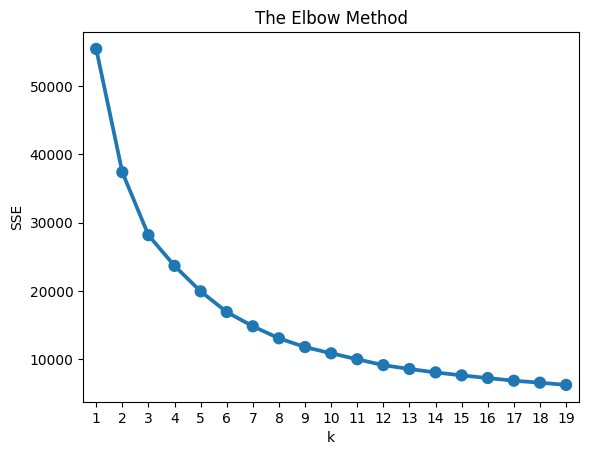

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
#plt.savefig("elbow.png")
plt.show()

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize the notebook mode
init_notebook_mode(connected=True)

# Create a scatter plot
scatter = go.Scatter(
    x=df_return['Recency'],
    y=df_return['Frequency'],
    mode='markers',
    marker=dict(
        size=df_return['MonetaryValue'],
        color=df_return['Rank'],
        colorscale='Viridis',
        showscale=True
    ),
    text=df_return['customerId'],
    hovertemplate='Customer ID: %{text}<br>Cluster: %{marker.color}<br>Rank: %{text}',
)

data = [scatter]

# Create layout
layout = go.Layout(
    title='RFM Bubble Chart',
    xaxis=dict(title='Recency'),
    yaxis=dict(title='Frequency'),
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the plot in the Jupyter Notebook
iplot(fig)


In [ ]:
tes = {'customerId': _arg1.values, 'OrderDate': _arg2.values,'OrderID':_arg3.values ,'currencyAmount':_arg4.values}

for column_name, column_data in tes.items():
    if column_data.ndim == 1:
        print(f"{column_name} is 1-dimensional")
    else:
        print(f"{column_name} is not 1-dimensional")
#df = pd.DataFrame(data=tes)
# max_date = max(df.OrderDate) + datetime.timedelta(days=1)
# customers = df.groupby(['customerId']).agg({
#     'OrderDate': lambda x: (max_date - x.max()).days,
#     'OrderID': 'count',
#     'currencyAmount': 'sum'})

# # Rename columns
# customers.rename(columns = {'OrderDate': 'Recency',
#                             'OrderID': 'Frequency',
#                             'currencyAmount': 'MonetaryValue'}, inplace=True)


# #Calculate R and F groups--
# # Create labels for Recency and Frequency
# r_labels = range(4, 0, -1); f_labels = range(1, 5)
# # Assign these labels to 4 equal percentile groups 
# r_groups = pd.qcut(customers['Recency'], q=4, labels=r_labels)
# # Assign these labels to 4 equal percentile groups 
# f_groups = pd.qcut(customers['Frequency'], q=4, labels=f_labels)
# # Create new columns R and F 
# customers = customers.assign(R_Score = r_groups.values, F_Score = f_groups.values)
# # Create labels for MonetaryValue
# m_labels = range(1, 5)
# # Assign these labels to three equal percentile groups 
# m_groups = pd.qcut(customers['MonetaryValue'], q=4, labels=m_labels)
# # Create new column M
# customers = customers.assign(M_Score = m_groups.values)

# # Set the Numbers
# customers_fix = pd.DataFrame()
# customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
# customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
# customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(customers_fix)
# customers_normalized = scaler.transform(customers_fix)


# from sklearn.cluster import KMeans

# # Find optimal number of clusters using the Elbow method
# sse = {}
# for k in range(1, 30):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(customers_normalized)
#     sse[k] = kmeans.inertia_

# # Find the number of clusters based on the Elbow method
# # Identify the "elbow" point in the SSE plot
# elbow_k = 0
# prev_sse = float('inf')
# for k, sse_value in sse.items():
#     if k > 1:
#         sse_diff = prev_sse - sse_value
#         if sse_diff < 0.1 * prev_sse:  # Adjust the threshold as per your preference
#             elbow_k = k - 1
#             break
#     prev_sse = sse_value

# # Create the K-means model with the optimal number of clusters
# model = KMeans(n_clusters=elbow_k, random_state=42)
# model.fit(customers_normalized)
# customers["Cluster"] = model.labels_

# df_return = pd.merge(df,customers,left_on='customerId',right_on='customerId', how='left')
